# Null model: synthetic networks

## Packages and settings

In [35]:
#sets the notebook width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%load_ext autoreload
%autoreload 2

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import sys
import math
import numpy as np
import pandas as pd
from scipy import stats
import networkx as nx
from sklearn.preprocessing import binarize
import seaborn as sns

In [3]:
sys.path.append('../src/')
from functions import *

In [4]:
stdrcparams(usetex=True)
figsize=stdfigsize(ratio=-1)
xs,ys=figsize
figsize

(11.32623792125, 7)

# Load data

## Raw data

In [5]:
countries=pd.read_csv("../data/countries.csv",delimiter=",",index_col=None)
countries.head()

,Country,Abbreviation,Latitude,Longitude
0,Australia,AUS,-25.274398,133.775136
1,Austria,AUT,47.516231,14.550072
2,Belgium,BEL,50.503887,4.469936
3,Bulgaria,BGR,42.733883,25.485830
4,Brazil,BRA,-14.235004,-51.925280


In [6]:
sectors=pd.read_csv("../data/sectors.csv",delimiter="\t",index_col=None)
sectors.head()

,Code,Activity
0,A01,"Crop and animal production, hunting and relate..."
1,A02,Forestry and logging
2,A03,Fishing and aquaculture
3,B,Mining and quarrying
4,C10$-$C12,"Manufacture of food products, beverages and to..."


# Null model

* Prestige - centrality related to in-coming links, null model: shuffle out-going links and preserve in-strength
* Importance - centrality related to out-going links, null model:  shuffle in-coming links and preserve out-strength

## Null model examples

In [7]:
def null_model(supramatrix,nodes=43,layers=56):
    """ 
    This model reshuffle the links and weights by blocks/layer of the supra-matrix. 
    Thus, the reshuffled matrix has the same degree, strength, and weight distributon of both layer and node.
    """
    m=supramatrix.copy()
    for i in range(0,layers):
        for j in range(0,layers):
            for k in range(0,nodes):
                np.random.shuffle(m[i*nodes:(i+1)*nodes,j*nodes:(j+1)*nodes][k])
    return m

In [8]:
data=np.array([[1,0,3,10],
               [0,3,4,1],
               [2,10,0,1],
               [0,5,0,1],
              ])

[]

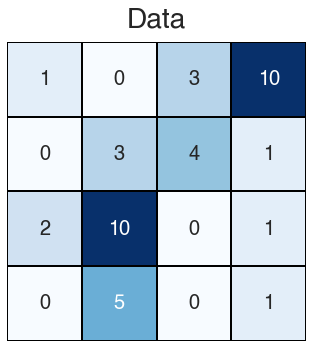

In [9]:
fig, ax = plt.subplots(figsize=(7,5.5))
ax=sns.heatmap(data,
               cmap='Blues',
               annot=True,
               cbar=False,
               linecolor='black',
               linewidth=2,
               square=True,
               annot_kws={"size": 20})
ax.set_title('Data')
ax.set_yticks([])
ax.set_xticks([])

[]

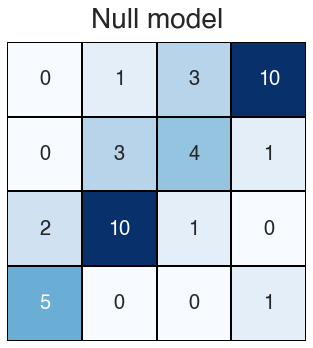

In [10]:
null=null_model(supramatrix=data,nodes=2,layers=2)

fig, ax = plt.subplots(figsize=(7,5.5))
ax=sns.heatmap(null,
               cmap='Blues',
               annot=True,
               cbar=False,
               linecolor='black',
               linewidth=2,
               square=True,
               annot_kws={"size": 20})
ax.set_title('Null model')
ax.set_yticks([])
ax.set_xticks([])

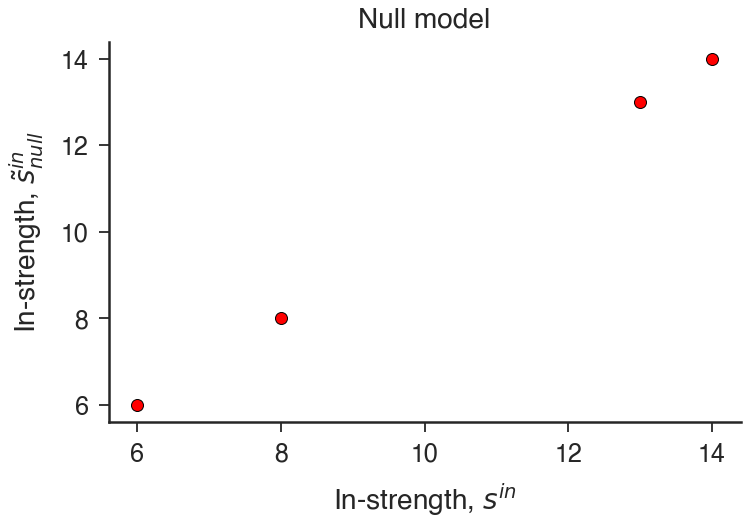

In [11]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(np.sum(data,axis=1),np.sum(null,axis=1),marker='o',
            color='r',
            markeredgecolor='k',
            markersize=12,
            linewidth=0,
          )
ax.set_xlabel(r'In-strength, $s^{ in}$')
ax.set_ylabel(r'In-strength, $\tilde{s}^{ in}_{null}$')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_title('Null model')
custom_frame(ax)
plt.show()

In [12]:
data=np.random.lognormal(size=16).reshape((4,4))
data

array([[0.65646151, 0.64319806, 0.29555762, 0.47008715],
       [0.97055806, 1.58703742, 0.62100748, 0.59559419],
       [0.25024173, 4.3402713 , 0.20558151, 0.11683273],
       [0.83493758, 0.88310188, 3.07326902, 0.38491374]])

In [13]:
centrality=mnet_eigen_centrality(data.T,node_labels=[1,2],n_layers=2 ,n_nodes=2,max_iter=1000)
bc=np.array(list(centrality.values()))
print(bc)
ipr_real=np.sum(bc**4)
print(ipr_real)

[0.58615937 0.81019577]
0.5489326733366557


In [14]:
centrality=mnet_eigen_centrality(null_model(data.T,nodes=2,layers=2),node_labels=[1,2],n_layers=2 ,n_nodes=2,max_iter=1000)
bc=np.array(list(centrality.values()))
print(bc)
ipr_real=np.sum(bc**4)
print(ipr_real)

[0.95985109 0.28051005]
0.8550111600331768


# Ensemble

In [15]:
#!/usr/bin/python
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 

from multiprocessing import Pool
from functools import partial

countries=pd.read_csv("../data/countries.csv",delimiter=",",index_col=None)

def read_edge_df(year=2010):
    data_path="../data/{}/multilayer/edges-{}.csv".format(year,year)
    print(data_path)
    edge_df=pd.read_csv(data_path)
    return edge_df


def edges_to_supramatrix(edge_df):
    number_of_countries=43
    number_of_layers=56
    m=np.zeros((number_of_layers*number_of_countries,number_of_layers*number_of_countries))
    for alpha in range(1,number_of_layers+1,1):
        for beta in range(1,number_of_layers+1,1):
            edges=edge_df[(edge_df.source_layer==alpha)& (edge_df.destination_layer==beta)][["source_node","destination_node",'weight']]
            edges=np.array(edges)
            for edge in edges:
                m[number_of_countries*(alpha-1):number_of_countries*alpha,
                  number_of_countries*(beta-1):number_of_countries*beta][int(edge[0]-1)][int(edge[1]-1)]=edge[2]
    return m

def multiplex_supra_matrix(edge_df):
    number_of_countries=43
    number_of_layers=56
    m=np.zeros((number_of_layers*number_of_countries,number_of_layers*number_of_countries))
    for beta in range(1,number_of_layers+1,1):
        for alpha in range(1,number_of_layers+1,1):
            edges=edge_df[(edge_df.source_layer==alpha) & (edge_df.destination_layer==beta)][["source_node","destination_node",'weight']]
            edges=np.array(edges)
            for edge in edges:
                m[number_of_countries*(alpha-1):number_of_countries*alpha,
                  number_of_countries*(beta-1):number_of_countries*beta][int(edge[0]-1)][int(edge[1]-1)]=edge[2]
    return m

def convert_to_matrices(edge_df,year):
    print('Convert edge list to multilayer matrix: {}'.format(year))
    ml=edges_to_supramatrix(edge_df)
    return ml

def null_model(supramatrix,n_nodes=43,n_layers=56):
    """ 
    This model reshuffle the links and weights by blocks/layer of the supra-matrix. 
    Thus, the reshuffled matrix has the same degree, strength, and weight distributon of both layer and node.
    """
    m=supramatrix.copy()
    for i in range(0,n_layers):
        for j in range(0,n_layers):
            for k in range(0,n_nodes):
                np.random.shuffle(m[i*n_nodes:(i+1)*n_nodes,j*n_nodes:(j+1)*n_nodes][k])
    return m

def mnet_eigen_centrality(M,node_labels,n_layers,n_nodes,max_iter=50):
    """
    Calculates the eingenvector centrality for a multilayer network. 

    
    De Domenico, M. et al. Ranking in interconnected multilayer
    networks reveals versatile nodes. Nat. Commun. 6:6868 doi: 10.1038/ncomms7868
    (2015).
    
    input: 
        - M is an numpy array with the supra matrix of the multilayer network.
        - n_layers is the number of layers
        - n_nodes is the number of nodes in each layer
    output: 
        - centralitymnet is the centrality of each node using the whole multilayer structure.
    
    """
    import scipy as sp
    from scipy.sparse import linalg 
    eigenvalue, eigenvector = linalg.eigs(M.T, k=1, which='LR' ,maxiter=max_iter )
    largest = eigenvector.flatten().real
    norm = sp.sign(largest.sum())*sp.linalg.norm(largest)
    centrality = largest/norm
    centrality=largest.reshape((n_layers,n_nodes))
    u=np.array([1 for i in range(0,n_layers)])
    centralitymnet=u.dot(centrality)
    norm = sp.sign(centralitymnet.sum())*sp.linalg.norm(centralitymnet)
    centralitymnet = centralitymnet/norm
    if node_labels==False:
         centralitymnet=dict(zip(np.arange(0,len(centralitymnet)),centralitymnet))
    else:
        centralitymnet=dict(zip(node_labels,centralitymnet))
    return centralitymnet

def core_ipr_ensemble(m,n_layers,i):
    null_m=null_model(supramatrix=m,n_nodes=43,n_layers=n_layers)
    centrality_null=mnet_eigen_centrality(null_m,node_labels=list(countries.Country),n_layers=n_layers ,n_nodes=43,max_iter=1000000)
    bc=np.array(list(centrality_null.values()))
    ipr=np.sum(bc**4)
    return ipr

def calculate_samples(m,nsamples,which,simplex=True):
    print(nsamples)
    
    if simplex:
        n_layers=1
    else:
        n_layers=56

    if which!='import':
        m=m.T

    #Calculate centrality for real network
    centrality=mnet_eigen_centrality(m,node_labels=list(countries.Country),n_layers=n_layers ,n_nodes=43,max_iter=1000000)
    bc=np.array(list(centrality.values()))
    ipr_real=np.sum(bc**4)

    #Calculate centrality for an ensemble of networks
    pool=Pool(processes=3)
    func=partial(core_ipr_ensemble,m,n_layers)
    ipr_ensemble=pool.map(func, np.arange(nsamples))
    pvalue=(np.sum(np.array(ipr_ensemble)>=ipr_real)/len(ipr_ensemble))*2
    results=[ipr_real,np.mean(ipr_ensemble),np.std(ipr_ensemble),np.percentile(ipr_ensemble,2.5),np.percentile(ipr_ensemble,97.5),pvalue]

    return results,ipr_ensemble

In [17]:
# Set parameters
NSAMPLES=1000

# Read data
print('Reading data \n')
m_list_multilayer=[]
for year in range(2000,2015):
    print('Reading edge list {} \n'.format(year))
    edge_df=read_edge_df(year=year)
    ml=convert_to_matrices(edge_df,year)
    m_list_multilayer.append(ml)

Reading data 

Reading edge list 2000 

../data/2000/multilayer/edges-2000.csv
Convert edge list to multilayer matrix: 2000
Reading edge list 2001 

../data/2001/multilayer/edges-2001.csv
Convert edge list to multilayer matrix: 2001
Reading edge list 2002 

../data/2002/multilayer/edges-2002.csv
Convert edge list to multilayer matrix: 2002
Reading edge list 2003 

../data/2003/multilayer/edges-2003.csv
Convert edge list to multilayer matrix: 2003
Reading edge list 2004 

../data/2004/multilayer/edges-2004.csv
Convert edge list to multilayer matrix: 2004
Reading edge list 2005 

../data/2005/multilayer/edges-2005.csv
Convert edge list to multilayer matrix: 2005
Reading edge list 2006 

../data/2006/multilayer/edges-2006.csv
Convert edge list to multilayer matrix: 2006
Reading edge list 2007 

../data/2007/multilayer/edges-2007.csv
Convert edge list to multilayer matrix: 2007
Reading edge list 2008 

../data/2008/multilayer/edges-2008.csv
Convert edge list to multilayer matrix: 2008
Read

In [25]:
# Multilayer
values=[]
ensembles=[]
for m in m_list_multilayer[:]:
    results,ipr_ensemble=calculate_samples(np.array(m),1000,'sellers',simplex=False)
    values.append(results)
    ensembles.append(ipr_ensemble)


dataframe=pd.DataFrame(np.transpose(ensembles),columns=[2000+i for i in range(0,15)])

dataframe.to_csv('../results/null_model/ipr_sellers.csv')

In [27]:
# Multilayer
values=[]
ensembles=[]
for m in m_list_multilayer[:]:
    results,ipr_ensemble=calculate_samples(np.array(m),1000,'import',simplex=False)
    values.append(results)
    ensembles.append(ipr_ensemble)


dataframe=pd.DataFrame(np.transpose(ensembles),columns=[2000+i for i in range(0,15)])

dataframe.to_csv('../results/null_model/ipr_buyers.csv')

# Box-plot

Before running this section, go to the terminal and:
- go to scripts folder;
- run `python null_models.py`

In [20]:
from matplotlib.ticker import MaxNLocator

In [28]:
df_buyers=pd.read_csv('../results/null_model/ipr_buyers.csv',index_col=0)
df_buyers.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,0.728057,0.703235,0.531315,0.960976,0.487033,0.564695,0.610545,0.641856,0.489226,0.516491,0.490365,0.457603,0.455086,0.455999,0.468551
1,0.030026,0.027801,0.031424,0.037253,0.035769,0.030677,0.032898,0.030479,0.029978,0.033474,0.033548,0.037969,0.038303,0.042457,0.042959
2,0.521568,0.450359,0.371779,0.465743,0.465598,0.551784,0.544026,0.603402,0.660006,0.667817,0.657500,0.701892,0.738036,0.752362,0.747425
3,0.892665,0.902244,0.892013,0.871504,0.889928,0.881935,0.875519,0.859110,0.441883,0.455997,0.501271,0.552849,0.572707,0.609845,0.596281
4,0.054895,0.051424,0.050644,0.052707,0.051667,0.050652,0.056158,0.053328,0.043220,0.046076,0.037363,0.033766,0.033088,0.033058,0.033147


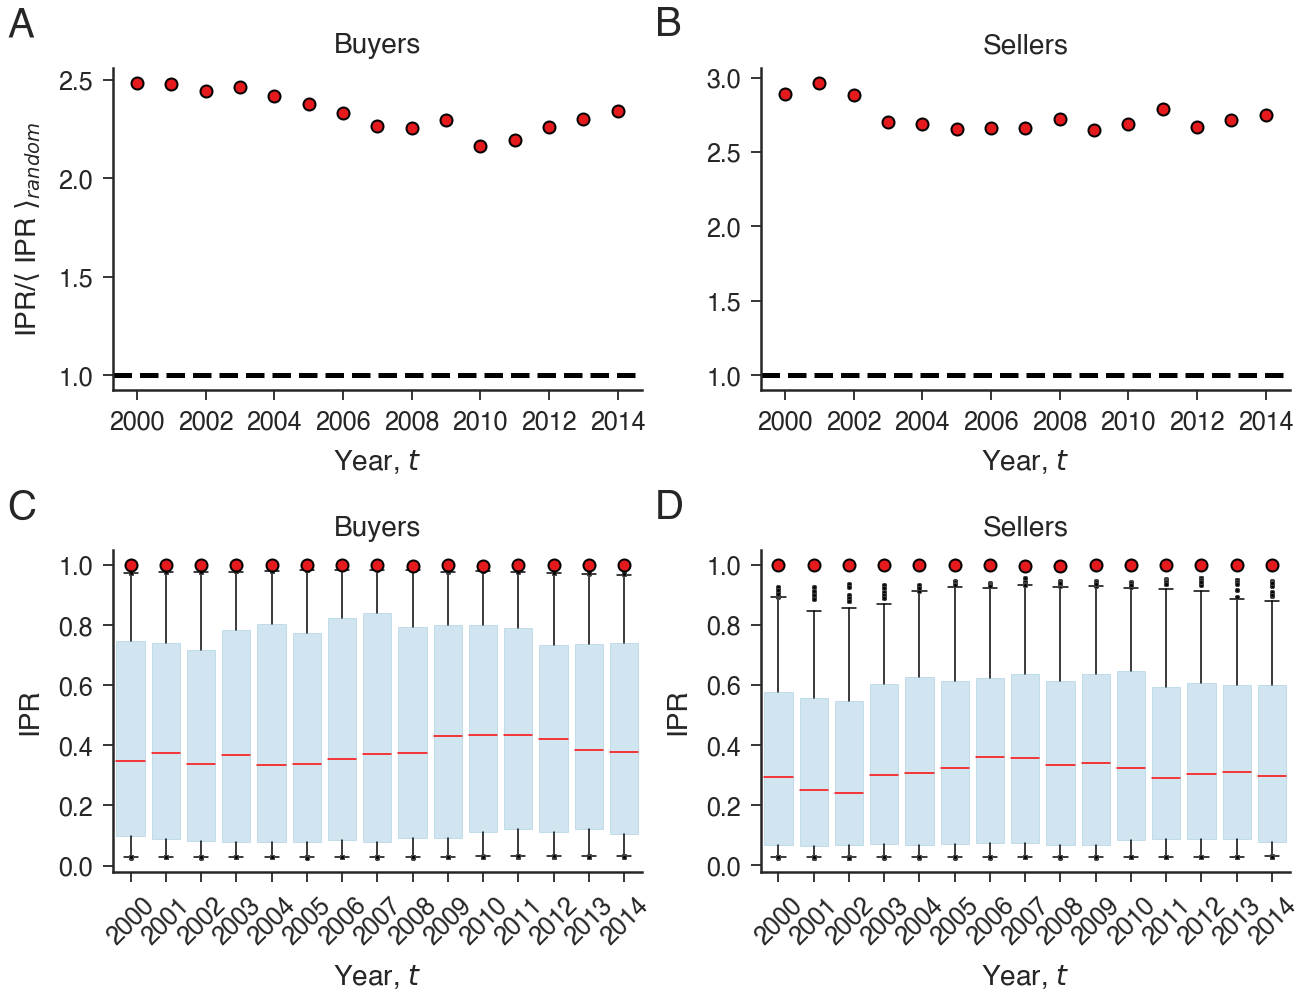

In [29]:
f, axs = plt.subplots(nrows=2, ncols=2, figsize=stdfigsize(nx=2, ny=2, scale=1))

ax=axs.flatten()[0]


df=pd.read_csv('../results/null_model/multilayer_buyers.csv',index_col=0)
ipr,m,s,lp,up,p=np.transpose(df.values)
x=np.array([int(year) for year in range(2000,2015)])
y=ipr/m


ax.plot(x,y[y>up/m],
        marker='o',
        color='#e41a1c',
        markeredgecolor='k',
        markeredgewidth=2,
        markersize=12,
        linewidth=0)

ax.axhline(y=1,linestyle='dashed',color='k')

ax.set_title('Buyers')
ax.set_xlabel(r'Year, $t$')
ax.set_ylabel(r'IPR/$\langle$ IPR $\rangle_{random}$')
ax.annotate('A', xy=(-0.2, 1.1), xycoords="axes fraction",fontsize=40,fontweight="bold")
custom_frame(ax)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax=axs.flatten()[1]


df=pd.read_csv('../results/null_model/multilayer_sellers.csv',index_col=0)
ipr,m,s,lp,up,p=np.transpose(df.values)
x=np.array([year for year in range(2000,2015)])
y=ipr/m


ax.plot(x,y[y>up/m],
        marker='o',
        color='#e41a1c',
        markeredgecolor='k',
        markeredgewidth=2,
        markersize=12,
        linewidth=0)


ax.axhline(y=1,linestyle='dashed',color='k')
ax.set_title('Sellers')
ax.set_xlabel(r'Year, $t$')
#ax.set_ylabel(r'IPR/$\langle \text{IPR} \rangle_{\text{random}}$')
ax.annotate('B', xy=(-0.2, 1.1), xycoords="axes fraction",fontsize=40,fontweight="bold")
custom_frame(ax)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax=axs.flatten()[2]



boxprops = dict(linewidth=1,color='#67a9cf',alpha=0.3)
flierprops = dict(marker='.', markerfacecolor='k', markersize=8, linestyle='none')
whiskerprops = dict(linewidth=1.5, color='k')
medianprops=dict(linewidth=1.5, color='r')
capprops=dict(linewidth=1.5, color='k')

df_buyers=pd.read_csv('../results/null_model/ipr_buyers.csv',index_col=0)
sns.boxplot(data=df_buyers,ax=ax,linewidth=2,fliersize=3,whis=[2.5, 97.5],
            capprops=capprops,
            flierprops=flierprops, 
            boxprops=boxprops, 
            whiskerprops=whiskerprops,
            medianprops=medianprops)

df=pd.read_csv('../results/null_model/multilayer_buyers.csv',index_col=0)
ipr,m,s,lp,up,p=np.transpose(df.values)
x=np.array([year for year in range(0,15)])
y=ipr

ax.plot(x,y,
        marker='o',
        color='#e41a1c',
        markeredgecolor='k',
        markeredgewidth=2,
        markersize=12,
        linewidth=0)


ax.set_title('Buyers')
ax.set_ylabel(r"IPR")
ax.set_xlabel(r"Year, $t$")
# ax.set_ylim(0.994,1.002)
custom_frame(ax)
ax.tick_params(axis='x', rotation=45)
ax.annotate('C', xy=(-0.2, 1.1), xycoords="axes fraction",fontsize=40,fontweight="bold")


ax=axs.flatten()[3]

boxprops = dict(linewidth=1,color='#67a9cf',alpha=0.3)
flierprops = dict(marker='.', markerfacecolor='k', markersize=8, linestyle='none')
whiskerprops = dict(linewidth=1.5, color='k')
medianprops=dict(linewidth=1.5, color='r')
capprops=dict(linewidth=1.5, color='k')

df_sellers=pd.read_csv('../results/null_model/ipr_sellers.csv',index_col=0)

sns.boxplot(data=df_sellers,ax=ax,linewidth=2,fliersize=3,whis=[2.5, 97.5],
            capprops=capprops,
            flierprops=flierprops, 
            boxprops=boxprops, 
            whiskerprops=whiskerprops,
            medianprops=medianprops)


df=pd.read_csv('../results/null_model/multilayer_sellers.csv',index_col=0)
ipr,m,s,lp,up,p=np.transpose(df.values)
x=np.array([year for year in range(0,15)])
y=ipr

ax.plot(x,y,
        marker='o',
        color='#e41a1c',
        markeredgecolor='k',
        markeredgewidth=2,
        markersize=12,
        linewidth=0)


ax.set_title('Sellers')
ax.set_ylabel(r"IPR")
ax.set_xlabel(r"Year, $t$")
# ax.set_ylim(0.994,1.002)
custom_frame(ax)
ax.tick_params(axis='x', rotation=45)
ax.annotate('D', xy=(-0.2, 1.1), xycoords="axes fraction",fontsize=40,fontweight="bold")
f.tight_layout()
plt.savefig('../figures/comparison_null.pdf',bbox_inches='tight',dpi=200)

In [30]:
import watermark
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Jun 02 2022

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.18.1

pandas    : 1.3.4
matplotlib: 3.4.3
scipy     : 1.7.3
networkx  : 2.4
seaborn   : 0.11.2
numpy     : 1.21.4
sys       : 3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:50:38) 
[Clang 11.1.0 ]
watermark : 2.3.0

Watermark: 2.3.0

